In this notebook, I build 3 classification models to predict the job title given a job description. The 3 classification models I used are the Naive bayes classifier, Logistic regression classifier and Keras with LSTM layers.

#### Import libraries

In [56]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import matplotlib.pyplot as plt
import string
import os
import pandas as pd
import numpy as np
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

#### Cleaner function

In [28]:
# Stop word list to filter noise in bag of words
stop_list = stopwords.words('english')

# All letters except for r, need to keep r because r represents R programming language
letters = string.ascii_lowercase[:17] + string.ascii_lowercase[18:]
letters_list = [letters[l] for l in range(len(letters))]

WNL = WordNetLemmatizer()

punct_list = [punctuation[p] for p in range(len(punctuation))]
add_stop_words = ['class', 'div', 'description__text', 'ul', 
                  'li', 'br', 'ul', 'job', 'description', 'rich', 
                  'strong', 'to', 'apply', 'visit', 'the', 'and',
                  'make', 'at', 'you', 'we', 'our', 'would', 'via',
                  'pte', 'ltd', 'us', 'please', 'lt', 'weight', 'gt',
                  'span', 'em']

stop_list += punct_list + add_stop_words + letters_list

def cleaner(x):
    output = []
    x = re.sub(r'<[\sa-zA-Z0-9=\-_/"]+>', ' ', x)
    for w in x.split():
        curr_word = WNL.lemmatize(w)
        curr_word = curr_word.lower()
        curr_word = re.sub(r'[^\w\s]', '', curr_word)
        if curr_word not in stop_list:
            output.append(curr_word)
    return ' '.join(output)

# stop_list

#### Combine all scraped_data csv to a single df

In [29]:
# Combine all csv files to one master csv file
datafolder = './scraped_data/'
allfiles = [f for f in os.listdir(datafolder) if os.path.isfile(f"{datafolder}{f}")]

d = {'Job Title': [], 'Company Name': [], 'Country': [], 'When Posted': [], 'No. of Applicants': [], 'Hyperlink': [], 'Job Description': [], 'Job Search': []}
master = pd.DataFrame(data = d)

for f in allfiles:
    print('loading {} ...'.format(f))
    df = pd.read_csv(datafolder + f)
    
    # Remove error rows
    df = df.loc[df['Job Title'] != 'error']
    
    # Remove duplicates
    duplicate_rows = df.duplicated(subset = ['Job Title', 'Company Name'], keep = 'first') # returns True for all 2nd duplicated rows
    duplicate_rows_list = duplicate_rows.tolist()  
    df = df[~duplicate_rows]
    
    # Create new column job search
    df['Job Search'] = f.split('_')[1].split('.')[0]
    
    # Clean job description
    df['Job Description'] =  df['Job Description'].replace(np.nan, '')
    df['Job Description'] = df.apply(lambda x: cleaner(str(x['Job Description'])), axis = 1)
        
    master = master.append(df, ignore_index = True)

loading linkedin_data science.csv ...
loading linkedin_software developer.csv ...
loading linkedin_cybersecurity.csv ...
loading linkedin_human resource.csv ...
loading linkedin_operations.csv ...
loading linkedin_business analyst.csv ...


#### Create integer label column for classification later

In [30]:
def job_labeler(text):
    label_id = 1
    label_dict = {}
    for i in text:
        i = i.split('_')[1].split('.')[0]
        label_dict[i] = label_id
        label_id += 1
    return label_dict

job_labels = job_labeler(allfiles)

master['label'] = master['Job Search'].apply(lambda x: job_labels[x])

# Check DF so far
master.head(3)

,Job Title,Company Name,Country,When Posted,No. of Applicants,Hyperlink,Job Description,Job Search,label
0,Intern| Data Scientist - Computer Vision (Nov2...,Gojek,Singapore| Singapore,2 days ago,63 applicants,https://sg.linkedin.com/jobs/view/intern-data-...,role intern use statistic machine learning pow...,data science,1
1,Intern| Data Science,Yara International,Singapore| Singapore,1 day ago,Be among the first 25 applicants,https://sg.linkedin.com/jobs/view/intern-data-...,yara part global network collaborating profita...,data science,1
2,CRISP - Data Scientist,Deloitte,Singapore| Singapore,3 weeks ago,Over 200 applicants,https://sg.linkedin.com/jobs/view/crisp-data-s...,responsibilities participate designing execut...,data science,1


#### Split to train and test set

In [35]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(master['Job Description'], master['label'], test_size = 0.2, random_state = 123, stratify = master['Job Search'])

# For deep learning model, convert output labels to numpy before fitting to model
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Check if test and train sets are stratified
print('\033[1m' + 'Train set distribution:' + '\033[0m')
print(pd.value_counts(y_train))
print('\033[1m' + '\nTest set distribution:' + '\033[0m')
print(pd.value_counts(y_test))

Train set distribution:
5    755
3    739
4    733
1    731
6    730
2    705
Name: label, dtype: int64

Test set distribution:
5    189
3    185
4    184
1    183
6    182
2    176
Name: label, dtype: int64


# NB Classifier
Transform training data into a tf-idf vectorizer and fit it into a Multinomial Naive Bayes classifier model.

In [38]:
# Fit and transform the training data
tf = TfidfVectorizer()
x_train_tfidf = tf.fit_transform(x_train)

In [41]:
# Create model instance
NB_model = MultinomialNB()

# Fit to training data
NB_model.fit(x_train_tfidf, y_train)

# Vectorize test data using same tf object
x_test_tfidf = tf.transform(x_test)

In [46]:
# Print classification report
nb_predicted_labels = NB_model.predict(x_test_tfidf)
print(classification_report(y_test, nb_predicted_labels))

              precision    recall  f1-score   support

           1       0.75      0.75      0.75       183
           2       0.89      0.84      0.86       176
           3       0.93      0.83      0.87       185
           4       0.82      0.90      0.86       184
           5       0.74      0.72      0.73       189
           6       0.70      0.77      0.74       182

    accuracy                           0.80      1099
   macro avg       0.81      0.80      0.80      1099
weighted avg       0.81      0.80      0.80      1099



# LR Classifier
Fit tf-idf vectorizer into a Logistic Regression classifier model.

In [49]:
# Create model instance
LR_model = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 123)

# Fit to training data
LR_model.fit(x_train_tfidf, y_train)

In [51]:
# Print classification report
lr_predicted_labels = LR_model.predict(x_test_tfidf)
print(classification_report(y_test, lr_predicted_labels))

              precision    recall  f1-score   support

           1       0.78      0.79      0.79       183
           2       0.85      0.93      0.89       176
           3       0.97      0.80      0.88       185
           4       0.91      0.89      0.90       184
           5       0.72      0.87      0.78       189
           6       0.83      0.73      0.78       182

    accuracy                           0.83      1099
   macro avg       0.84      0.83      0.83      1099
weighted avg       0.84      0.83      0.83      1099



# Deep Learning - LSTM

Histogram of length of job descriptions. Set max words to 350 for dense vectors.

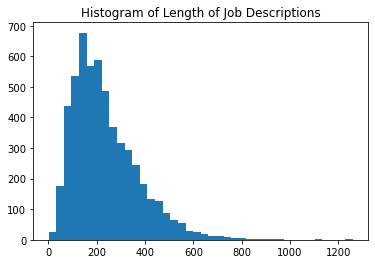

In [54]:
def find_length(x):
    return(len(x.split()))

master['Length of Job Descriptions'] = master.apply(lambda x: find_length(x['Job Description']), axis = 1)

# Max number of words in a sequence
max_length = 350

plt.hist(master['Length of Job Descriptions'], bins = 40)
plt.title('Histogram of Length of Job Descriptions')
plt.show()

In [57]:
# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text = master['Job Description']
counter = counter_word(text)
num_words = len(counter)

In [59]:
# Create BOW
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [60]:
# Create train and test sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [61]:
# Clipping and padding
train_padded = pad_sequences(
    train_sequences, maxlen = max_length, padding = 'pre', truncating = 'pre')

test_padded = pad_sequences(
    test_sequences, maxlen = max_length, padding = 'pre', truncating = 'pre')

print('Shape of train {}'.format(str(train_padded.shape)))
print('Shape of test {}'.format(str(test_padded.shape)))

Shape of train (4393, 350)
Shape of test (1099, 350)


In [62]:
# Check inverse
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode(train_sequences[123])

'talented senior software engineer passionate creating new technology developing innovative solutions join next products amp platform pampp part onechat team create next generation collaboration platform ai powered secure chat amp video conferencing solution enterprises pampp leverage latest technology create groundbreaking product help accelerate client digital transformation agenda deep expertise robotics iot computer vision audio intelligence speech analytics much join role develop support internal product onechat serf communication platform ncs staff customers responsibilities designing developing highvolume lowlatency application missioncritical system delivering highavailability performance contribute phase development lifecycle write well designed testable efficient code ensure design compliance specification prepare produce release software component support continuous improvement investigating alternative technology presenting architectural review ideal candidate possess bsms 

In [65]:
# Build model
model = Sequential()

model.add(Embedding(num_words, 32, input_length = max_length))
model.add(LSTM(100, dropout = 0.1, return_sequences = True))
model.add(LSTM(50, dropout = 0.2))
model.add(Dense(10, activation = 'softmax'))

optimizer = Adam()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 32)           991296    
_________________________________________________________________
lstm_2 (LSTM)                (None, 350, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 1,075,206
Trainable params: 1,075,206
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(
    train_padded, y_train_array, epochs = 15,
    validation_split = 0.2)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/15
110/110 [==============================] - 95s 835ms/step - loss: 1.9737 - accuracy: 0.1666 - val_loss: 1.8136 - val_accuracy: 0.1638
Epoch 2/15
110/110 [==============================] - 92s 832ms/step - loss: 1.8120 - accuracy: 0.1444 - val_loss: 1.7977 - val_accuracy: 0.1923
Epoch 3/15
110/110 [==============================] - 91s 830ms/step - loss: 1.7926 - accuracy: 0.1820 - val_loss: 1.7840 - val_accuracy: 0.1593
Epoch 4/15
110/110 [==============================] - 91s 827ms/step - loss: 1.6842 - accuracy: 0.2968 - val_loss: 1.4495 - val_accuracy: 0.4653
Epoch 5/15
110/110 [==============================] - 90s 823ms/step - loss: 1.0311 - accuracy: 0.6607 - val_loss: 1.0691 - val_accuracy: 0.6086
Epoch 6/15
110/110 [==============================] - 92s 839ms/step - loss: 0.7475 - accuracy: 0.7562 - val_loss: 1.0920 - val_accuracy: 0.6234
Epoch 7/15
110/110 [==============================] - 90s 819ms/step - loss: 0.5649 - accuracy: 0.8265 - val_loss: 1.0299 - val_ac

In [78]:
# Accuracy of test data
test_loss, test_acc = model.evaluate(test_padded, y_test_array, verbose = 1)
print(f'Test accuracy: {test_acc}')

35/35 [==============================] - 6s 182ms/step - loss: 1.1424 - accuracy: 0.6706
Test accuracy: 0.6706096529960632


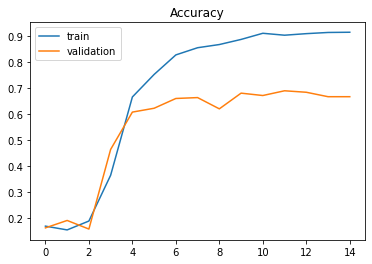

In [79]:
# Plot accuracy
plt.plot()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.legend()
plt.show()

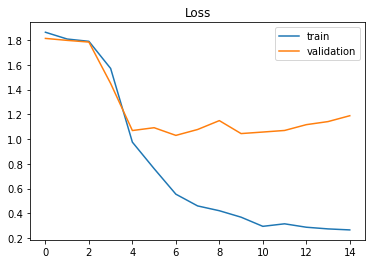

In [80]:
# Plot loss
plt.plot()
plt.title('Loss')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()